 **Landmark Recognition using ResNet50 and delf**

**Importing required modules** 

In [ ]:
# import the necessary packages
import tensorflow as  tf
from keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image  import ImageDataGenerator,load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.regularizers import l2
from keras import backend as K
from PIL import ImageOps
import sklearn.metrics
import tensorflow_hub as hub
import keras
import os
from absl import logging
import copy
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform
from six import BytesIO

import tensorflow as tf

import tensorflow_hub as hub
from six.moves.urllib.request import urlopen

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
img_height,img_width =(224,224)
batch_size =32

train_data_dir = "/content/drive/MyDrive/processed_data1/train"
test_data_dir = "/content/drive/MyDrive/processed_data1/test"
val_data_dir = "/content/drive/MyDrive/processed_data1/val"


**Data Augmentation**

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = "training"
)

valid_generator = image_dataset_from_directory(
    directory = val_data_dir,
    image_size = (img_height, img_width),
    batch_size = batch_size,
    label_mode='categorical'
)

Found 917 images belonging to 99 classes.
Found 97 files belonging to 99 classes.


In [ ]:
from PIL import Image
im = Image.open('/content/drive/MyDrive/processed_data1/train/India Gate/images.jpeg')


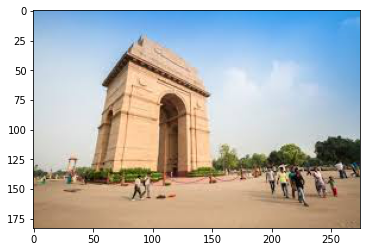

In [ ]:
plt.imshow(im)

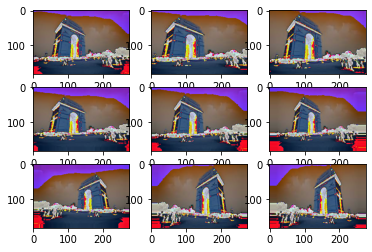

In [ ]:
from keras.preprocessing.image import img_to_array
from numpy import expand_dims
from matplotlib import pyplot
img = load_img('/content/drive/MyDrive/processed_data1/train/India Gate/images.jpeg')

data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
data = train_datagen.flow(samples,batch_size=1)
for i in range(9):
  pyplot.subplot(330 + 1 + i)
  batch = data.next()
  image = batch[0].astype('uint8')
  pyplot.imshow(image)
pyplot.show()


In [ ]:
test_generator = train_datagen.flow_from_directory(
    test_data_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical')

Found 197 images belonging to 99 classes.


**Model Training and fitting**

In [ ]:
base_model = ResNet50(include_top = False,weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
predictions = Dense(train_generator.num_classes,activation='softmax')(x)
model = Model(inputs=base_model.input,outputs = predictions)
for layer in base_model.layers:
  layer.trainable = False

model.compile(optimizer = 'adam', loss ='categorical_crossentropy',metrics = ['accuracy'])

model.fit(train_generator,validation_data=valid_generator,epochs = 25)

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/25
29/29 [==============================] - 579s 20s/step - loss: 3.6394 - accuracy: 0.2868 - val_loss: 2.4973 - val_accuracy: 0.3505
Epoch 2/25
29/29 [==============================] - 24s 824ms/step - loss: 0.8179 - accuracy: 0.8190 - val_loss: 1.7889 - val_accuracy: 0.5361
Epoch 3/25
29/29 [==============================] - 24s 811ms/step - loss: 0.2562 - accuracy: 0.9477 - val_loss: 1.4175 - val_accuracy: 0.6082
Epoch 4/25
29/29 [==============================] - 24s 823ms/step - loss: 0.1320 - accuracy: 0.9716 - val_loss: 1.2441 - val_accuracy: 0.6598
Epoch 5/25
29/29 [==============================] - 24s 832ms/step - loss: 0.0967 - accuracy: 0.9804 - val_loss: 1.1771 - val_accuracy: 0.7216
Epoch 6/25
29/29 [==============================] - 24s 820ms/step - loss: 0.0537 - accuracy: 0.9913 - val_loss: 1.2141 - val_accuracy: 0.6804
Epoch 7/25
29/29 [==============================] - 24s 815ms/step - loss: 0.0

In [ ]:
model.save('/content/drive/MyDrive/processed_data1/ResNet50_Fl.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
predict_model = model.predict(test_generator)

**Test Accuracy**

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/processed_data1/ResNet50_Fl.h5')
test_loss,test_acc = model.evaluate(test_generator,verbose=1)
print("\nTest accuracy: ", test_acc)

7/7 [==============================] - 5s 585ms/step - loss: 0.2552 - accuracy: 0.9442

Test accuracy:  0.9441624283790588


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

**Loading Delf module**

In [ ]:
delf = hub.load('https://tfhub.dev/google/delf/1').signatures['default']

In [ ]:
import warnings
warnings.filterwarnings("ignore")

**Calculating the inliers in the images**

In [ ]:
def match_images(image1, image2, result1, result2):
  distance_threshold = 0.8

  # Read features.
  num_features_1 = result1['locations'].shape[0]
  # print("Loaded image 1's %d features" % num_features_1)
  
  num_features_2 = result2['locations'].shape[0]
  # print("Loaded image 2's %d features" % num_features_2)

  # Find nearest-neighbor matches using a KD tree.
  d1_tree = cKDTree(result1['descriptors'])
  _, indices = d1_tree.query(
      result2['descriptors'],
      distance_upper_bound=distance_threshold)

  # Select feature locations for putative matches.
  locations_2_to_use = np.array([
      result2['locations'][i,]
      for i in range(num_features_2)
      if indices[i] != num_features_1
  ])
  locations_1_to_use = np.array([
      result1['locations'][indices[i],]
      for i in range(num_features_2)
      if indices[i] != num_features_1
  ])
  # print(locations_1_to_use,locations_2_to_use)
  # Perform geometric verification using RANSAC.
  if len(locations_1_to_use)>2:
    _, inliers = ransac(
        (locations_1_to_use, locations_2_to_use),
        AffineTransform,
        min_samples=2,
        residual_threshold=20,
        max_trials=1000) 
    if not isinstance(inliers, type(None)):
      # print(len(inliers))
      return len(inliers)
  return 0

**Running delf**

In [ ]:
def delf_tri(image):
  np_image = np.array(image)
  float_image = tf.image.convert_image_dtype(np_image,tf.float32)

  return delf(image = float_image,
              score_threshold = tf.constant(100.0),
              image_scales = tf.constant([0.25,0.3536,0.5,0.7061,1.0,1.4142,2.0]),
              max_feature_num= tf.constant(1000))

def run_delf(names_list,image_url,df):

  predict_image = Image.open(image_url)
  predict_image = ImageOps.fit(predict_image,(256,256),Image.ANTIALIAS)
  predict_result = delf_tri(predict_image)
  maximum_pro = 0
  label =""
  for j in names_list:
    fil = os.listdir(train_data_dir+'/'+j)
    i=0
    for k in fil:
      i+=1
      im = train_data_dir+'/'+j+'/'+k
      sample_image  = Image.open(im)
      if im not in df:
        sample_image = ImageOps.fit(sample_image,(256,256),Image.ANTIALIAS)
        df[im] = delf_tri(sample_image)
      # print(sample_result,predict_result,sep="IBONPB OBP: ")
      max = match_images(sample_image,predict_image,df[im],predict_result)
      if max!=None and maximum_pro<max:
        maximum_pro = max
        label  = j
      if i==2:
        break
      
  
  return label
      
      


**Implementing delf with test_data**

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/processed_data1/ResNet50_Fl.h5')
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
names = os.listdir(test_data_dir)
names.sort()
print(names)
# print(test_generator.classes)
c=0
g=0
d={}
total_count = test_generator.samples
for i in test_generator.filenames:
  g+=1
  image_url = test_data_dir+'/'+i
  image = Image.open(image_url)
  image = image.resize((224,224))
  im = np.expand_dims(image,axis=0)
  lis = model.predict(im)
  li = lis.tolist()
  li1 = copy.deepcopy(li[0])
  # print(li1)
  li1.sort(reverse=True)
  names_list=[]
  names_list.append(names[li[0].index(li1[0])])
  names_list.append(names[li[0].index(li1[1])])
  names_list.append(names[li[0].index(li1[2])])
  names_list.append(names[li[0].index(li1[3])])
  names_list.append(names[li[0].index(li1[4])])
  # names_list.append(names[li[0].index(li1[5])])
  # names_list.append(names[li[0].index(li1[6])])
  # names_list.append(names[li[0].index(li1[7])])
  # names_list.append(names[li[0].index(li1[8])])
  # names_list.append(names[li[0].index(li1[9])])
  images=[]
  # print(names_list)
  for j in names_list:
    fil = os.listdir(train_data_dir+'/'+j)
    for k in fil:
      images.append(train_data_dir+'/'+j+'/'+k)
  label = i.split('/')[0].strip()
  output_label = run_delf(names_list,image_url,d)

  print("actualLabel------->{}".format(label),"predictedlabel------------>{}".format(output_label),sep="        ")
  if(output_label.strip()==label or label == names_list[0].strip()):
    c+=1
  print(c,g)
final_accuracy=(c/total_count)*100

['Agam Kuan ', 'Albert Hall Museum', 'Ambernath Shivalaya, Ambernath', 'Bangalore Palace', 'Barabati Fort, Cuttack', 'Belur Math', 'Brahmeshwara Temple', 'Brihadeeswarar Temple', 'Buddha statue in Hussain Sagar', 'Central Sikh Museum', 'Chand Minar, Daulatabad', 'Chandragiri Fort', 'Charminar', 'Chennai Central', 'Chhatrapati Shivaji Terminus, Mumbai', 'Chhoti Dargah', 'Chowmahalla Palace', 'Cooch Behar Palace', 'Deekshabhoomi, Nagpur', 'Dhai Din Ka Jhopra', 'Dhauli, Bhubaneswar', 'Durga Temple,karnataka', "Elephant's Stables", 'Falaknuma Palace', 'Ghandi Hill', 'Global Vipassana Pagoda, Mumbai', 'Golghar ', 'Government Museum Chennai', 'Hawa Mahal', 'Hazarduari Palace', 'High Court of Andhra Pradesh', 'High Court of Karnataka', 'Howrah Bridge', 'India Gate', 'Jal Mahal', 'Jama Masjid', 'Jami Masjid, Mandu ', 'Jor Bangla Temple', 'Kabuli Bagh Masjid', 'Kala Thoranam', 'Kanker Palace ', 'Karnataka Vidhana Soudha', 'Laxman Temple ', 'Lotus mahal hampi', 'Lukshmi Vilas Palace', 'Madras Hi

**Accuracy after delf**

In [ ]:
print("accuracy after delf for 5 labels "+ str(final_accuracy))

accuracy after delf 95.93908629441624


**Predicting label of the given Image**

[3.1194645998766646e-05, 0.0004291506775189191, 2.2024982172297314e-05, 7.693532097619027e-05, 3.509593807393685e-05, 0.0003860577126033604, 5.854261871718336e-06, 4.345664638094604e-05, 7.862395432312042e-05, 1.9167744540027343e-05, 2.4248307454399765e-05, 8.094911754596978e-05, 0.0031125734094530344, 2.7946520276600495e-05, 0.0005222838371992111, 1.6062108443293255e-06, 5.718274405808188e-05, 2.070261507469695e-05, 1.6667985619278625e-05, 0.0031595611944794655, 0.0011019031517207623, 1.3633267599288956e-06, 5.474008958117338e-06, 0.00020274279813747853, 9.682682502898388e-06, 3.674148683785461e-05, 3.1153678719419986e-05, 0.0016135412734001875, 1.8008679035119712e-05, 7.313198875635862e-05, 0.0002614507684484124, 6.853828836028697e-06, 0.000203785122721456, 0.9053257703781128, 4.3207351154705975e-06, 0.00014685442147310823, 5.766303729615174e-06, 5.445208080345765e-05, 0.00018419847765471786, 0.0010320539586246014, 0.00016951689030975103, 0.0006920627201907337, 5.630669875245076e-06,

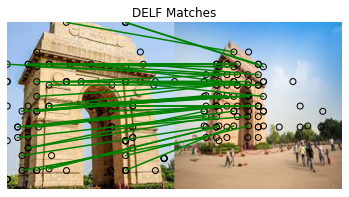

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
image = Image.open('/content/drive/MyDrive/processed_data1/train/India Gate/images.jpeg')
image = image.resize((224,224))
# im = np.asarray(image)
im = np.expand_dims(image, axis=0)
model = tf.keras.models.load_model('/content/drive/MyDrive/processed_data1/ResNet50_Fl.h5')
lis = model.predict(im)
li = lis.tolist()
names = os.listdir(test_data_dir)
names.sort()
li1 = copy.deepcopy(li[0])
print(li1)
li1.sort(reverse=True)
names_list=[]
names_list.append(names[li[0].index(li1[0])])
names_list.append(names[li[0].index(li1[1])])
names_list.append(names[li[0].index(li1[2])])
names_list.append(names[li[0].index(li1[3])])
names_list.append(names[li[0].index(li1[4])])
names_list.append(names[li[0].index(li1[5])])
names_list.append(names[li[0].index(li1[6])])
names_list.append(names[li[0].index(li1[7])])
names_list.append(names[li[0].index(li1[8])])
names_list.append(names[li[0].index(li1[9])])
images=[]
for j in names_list:
  fil = os.listdir(train_data_dir+'/'+j)
  for k in fil:
    images.append(train_data_dir+'/'+j+'/'+k)
print(names_list)
out = run_delf1(names_list,image)
print(out)

In [ ]:
def match_images1(image1, image2, result1, result2):
  distance_threshold = 0.8
  num_features_1 = result1['locations'].shape[0]
  
  num_features_2 = result2['locations'].shape[0]

  # Find nearest-neighbor matches using a KD tree.
  d1_tree = cKDTree(result1['descriptors'])
  _, indices = d1_tree.query(
      result2['descriptors'],
      distance_upper_bound=distance_threshold)

  # Select feature locations for putative matches.
  locations_2_to_use = np.array([
      result2['locations'][i,]
      for i in range(num_features_2)
      if indices[i] != num_features_1
  ])
  locations_1_to_use = np.array([
      result1['locations'][indices[i],]
      for i in range(num_features_2)
      if indices[i] != num_features_1
  ])
  # print(locations_1_to_use,locations_2_to_use)
  # Perform geometric verification using RANSAC.
  if len(locations_1_to_use)>2:
    _, inliers = ransac(
        (locations_1_to_use, locations_2_to_use),
        AffineTransform,
        min_samples=2,
        residual_threshold=20,
        max_trials=1000) 
    if not isinstance(inliers, type(None)):
      lis= [len(inliers),image1,image2,locations_1_to_use,locations_2_to_use,inliers]
      return lis
  return []

In [ ]:
def delf_tri1(image):
  np_image = np.array(image)
  float_image = tf.image.convert_image_dtype(np_image,tf.float32)

  return delf(image = float_image,
              score_threshold = tf.constant(100.0),
              image_scales = tf.constant([0.25,0.3536,0.5,0.7061,1.0,1.4142,2.0]),
              max_feature_num= tf.constant(1000))

def run_delf1(names_list,image):

  predict_image = image
  predict_image = ImageOps.fit(predict_image,(256,256),Image.ANTIALIAS)
  predict_result = delf_tri1(predict_image)
  maximum_pro = 0
  label =""
  for j in names_list:
    fil = os.listdir(train_data_dir+'/'+j)
    i=0
    for k in fil:
      i+=1
      im = train_data_dir+'/'+j+'/'+k
      sample_image  = Image.open(im)
      sample_image = ImageOps.fit(sample_image,(256,256),Image.ANTIALIAS)
      s_r = delf_tri1(sample_image)
      # print(sample_result,predict_result,sep="IBONPB OBP: ")
      ou = match_images1(sample_image,predict_image,s_r,predict_result)
      if len(ou)!=0:
        i1,i2,l1,l2,inlin=ou[1],ou[2],ou[3],ou[4],ou[5]
        if maximum_pro<ou[0]:
          maximum_pro = ou[0]
          label  = j
          a=i1
          b=i2
          c=l1
          d=l2
          e=inlin
        if i==2:
          break
  _, ax = plt.subplots()
  inlier_idxs = np.nonzero(e)[0]
  plot_matches(
      ax,
      a,
      b,
      c,
      d,
      np.column_stack((inlier_idxs, inlier_idxs)),
      matches_color='g')
  ax.axis('off')
  ax.set_title('DELF Matches')
  return label